In [89]:
from src.helper import *


class AdaptVQEData:
    def __init__(self, initial_energy, pool, sparse_pool, ref_determinant, backend, shots, prev_data = None):
        self.pool = pool
        self.sparse_pool = sparse_pool
        self.shots = shots
        self.backend = backend

        if prev_data is not None:
            self.initial_energy = initial_energy
            self.evolution = copy.deepcopy(prev_data.evolution)

            if not prev_data.result:
                raise ValueError("Previous data does not supply final results")
            
            self.current = copy.deepcopy(prev_data.result)
            self.iteration_count = prev_data.iteration_count

            if prev_data is not None:
                assert(len(self.sparse_pool) == len(prev_data.sparse_pool))

        else:
            self.initial_energy = initial_energy
            self.evolution = {}
            self.evolution["energies"] = []
            self.evolution["total norm"] = []
            self.evolution["selected_grad"] = []
            self.evolution["coefficients"] = []
            self.evolution["energy change"] = []
            self.evolution["indices"] = []

            self.current = {}
            self.current["ansatz"] = []
            self.current["coefficients"] = []
            self.current["indices"] = []
            self.current["ansatz performances"] = []
            self.current["performances"] = []
            self.current["energy"] = None
            self.current["state"] = None
            self.current["total norm"] = None

            self.iteration_count = 0
        
        self.closed = False
        self.success = False

        self.result = {}
            

    def processIteration(self, operator_idx, operator, energy, total_norm, selected_grad, coefficients):
        
        self.current["coefficients"] = copy.deepcopy(coefficients)
        
        if self.iteration_count == 0:
            prev_energy = self.initial_energy
        else:
            prev_energy = self.current['energy']

        energy_change = energy - prev_energy
        print("Energy Change:", energy_change)
        performance = np.abs(energy_change/selected_grad)

        self.current['ansatz performances'].append(performance)
        self.current['performances'].append(performance)

        ansatz_performance = np.average(self.current['ansatz performances'])
        print("Ansatz Performance:", ansatz_performance)
        
        self.current['ansatz'].append(operator)
        self.current['energy'] = energy
        self.current['indices'].append(operator_idx)
        self.current['total norm'] = total_norm

        coefficients_copy = copy.deepcopy(self.current['coefficients'])
        indices_copy = copy.deepcopy(self.current['indices'])

        self.evolution['energies'].append(energy)
        self.evolution['energy change'].append(energy_change)
        self.evolution['total norm'].append(total_norm)
        self.evolution['selected_grad'].append(selected_grad)
        self.evolution['indices'].append(indices_copy)
        self.evolution['coefficients'].append(coefficients_copy)
        self.iteration_count += 1
        

    def close(self, success):
        print("CLOSE")
        print("self.current:", self.current)
        self.result = self.current
        self.closed = True
        self.success = success

    def plot(self, plotGradient = True, detailedTitle = True):
        iteration_number = self.iteration_count
        iteration_labels = [ iterationLable for iterationLable in range(0, self.iteration_count+1)]

        gradient_norms = self.evolution['total norm']
        energies = [self.initial_energy] + self.evolution['energies']


        fig, ax1 = plt.subplots(figsize=[8,8])
        ax1.plot(iteration_labels, energies, '--o', color='navy')
        
        # exact_energy = self.molecule.fci_energy
        exact_energy = -1.13728
        min_accuracy = exact_energy - chemicalAccuracy
        max_accuracy = exact_energy + chemicalAccuracy
        l = ax1.axhspan(min_accuracy, max_accuracy, alpha=0.3, color='cornflowerblue')

        ax1.set_xlabel("Iteration Number")
        ax1.set_ylabel("Energy (au)", color='navy')

        plt.xticks(range(1, 1+ self.iteration_count))

        if plotGradient:
            color2 = 'r'
            ax2 = ax1.twinx()
            ax2.plot(iteration_labels[1:], gradient_norms, '--o', color='maroon')
            ax2.tick_params(axis='y', labelcolor='maroon')
            ax2.set_ylabel("Total Gradient Norm", color='maroon')

        
        


class AdaptVQE:
    def __init__(self, pool, molecule, backend, shots = 1024, max_iter = 50, verbose = False, threshold = 0.1, ref_determinant = None):

        # Init . . .
        self.pool = pool.copy()
        self.molecule = molecule
        self.backend = backend
        self.shots = shots
        self.max_iter = max_iter
        self.verbose = verbose
        self.threshold = threshold
        self.ref_determinant = ref_determinant

        # Hamiltonian and Refernce Value
        self.sparse_hamiltonian = get_sparse_operator(self.molecule.get_molecular_hamiltonian(), self.molecule.get_molecular_hamiltonian().n_qubits)

        self.qubit_hamiltonian = jordan_wigner(self.molecule.get_molecular_hamiltonian())
        dict_hamiltonian = convertHamiltonian(self.qubit_hamiltonian)
        self.hamiltonian = SparsePauliOp.from_list(list(dict_hamiltonian.items()))
        self.ref_value = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=self.hamiltonian).eigenvalue.real
        print(f"Reference value: {self.ref_value:.5f}")

        # Lists
        self.sparse_pool = []
        self.ansatz = []
        self.coefficients = []
        self.indices = []


    def prepare(self, sparse_pool = None, prev_data = None):

        # Sparse Pool
        if sparse_pool is None:
            print("Sparse poll was not provided. Obtaining it . . .")
            for operator in self.pool:
                self.sparse_pool.append(get_sparse_operator(operator, self.molecule.get_molecular_hamiltonian().n_qubits))
        else:
            self.sparse_pool = sparse_pool
        # print("Sparse Pool: ", self.sparse_pool)


        # Reference State Ket
        if self.ref_determinant is None:
            hartree_fock_ket = getHartreeFockKet(self.molecule.n_electrons, self.molecule.get_molecular_hamiltonian().n_qubits)
            print("\nHartree Fock Kate:", hartree_fock_ket)
            self.ref_determinant = hartree_fock_ket

        hartree_fock_vect = fromKettoVector(self.ref_determinant)
        print("Hartree Fock Vector:", hartree_fock_vect)
        self.reference_state = hartree_fock_vect


        # Reference State Vector
        self.sparse_reference_state = scipy.sparse.csc_matrix(self.reference_state, dtype=complex).transpose()
        print("Sparse Reference State:", self.sparse_reference_state)


        # Initial Energy
        initial_energy = self.calculateEnergy([],[])
        print("\nInitial Energy:", initial_energy)


        # Initialize Data
        self.data = AdaptVQEData(initial_energy, self.pool, self.sparse_pool, self.ref_determinant, self.backend, self.shots, prev_data)
        print("Data Current['state']:", self.data.current['state'])
        if self.data.current['state'] is None:
            print("Initially None, then Data Current['state']:", self.sparse_reference_state)
            self.data.current['state'] = self.sparse_reference_state
            
        print("Data Current['state'] Updated:", self.data.current['state'], '\n')

        print("ADAPT-VQE Configurations:")
        self.printSettings()
    

    def printSettings(self):
        print("> Convergence threshold (gradient norm): ", self.threshold)
        print("> Maximum number of iterations: ", self.max_iter)
        print("> Backend: ",self.backend)      
  

    def computeState(self):
        print("\n=== Compute State ===\n")
        state = self.sparse_reference_state # State = HF

        for (i, operator_idx) in enumerate(self.data.current['indices']):
            print(i, operator_idx)
            print("Compute State -> Current Data:", self.data.current['indices'])
            coeff = self.data.current['coefficients'][i]
            sparse_operator = self.sparse_pool[operator_idx].multiply(coeff)
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            state = exp_operator * state
        return state


    def calculateGradient(self, operator_idx):

        sparse_operator = self.sparse_pool[operator_idx]
        print("\nCalculate Gradient -> Sparse Operator:", sparse_operator)
        # print("\nCalculate Gradient -> Sparse Operator Type:", type(sparse_operator))

        current_state = self.data.current['state']
        print("\nCalculate Gradient -> Current Data State:", current_state)
        
        # print("sparse operator: >>", sparse_operator)
        # print("current state: >>", current_state)

        test_state = sparse_operator * current_state
        bra = current_state.transpose().conj()
        gradient = 2*(np.abs(bra*self.sparse_hamiltonian*test_state)[0,0].real)
        print("\nCalculate Gradient -> Gradient Value:", gradient)
        return gradient
    

    def selectOperator(self):
        selected_gradient = 0
        selected_idx = None
        total_norm = 0

        print("\nNon-zero Gradients (calculated, tolerance E-5)")

        # First, iterate through all operator in self pool
        print("Number of Operator inside the pool:", len(self.pool))
        for operator_idx in range(len(self.pool)):
            print("\nSelect Operator -> current operator idx:", operator_idx)

            gradient = self.calculateGradient(operator_idx)
            print("\n # # # Select Operator -> Calculated gradient of operator", operator_idx, ": ", gradient)
            
            total_norm += gradient**2

            if gradient > 10**-5:
                print("Select Operator -> {}: {}".format(operator_idx, gradient))

            if gradient > selected_gradient:
                selected_idx = operator_idx
                selected_gradient =  gradient

        total_norm = np.sqrt(total_norm)
        print("Select Operator -> Total gradient norm: {}".format(total_norm))
        
        return selected_idx, selected_gradient, total_norm
    

    def calculateEnergy(self, coefficients, indices):
        ket = self.sparse_reference_state
        print("\nCalculate Energy -> Ket:", ket)

        for (coeff, operator_idx) in zip(coefficients, indices):
            print("Coefficients:", coeff, "Indices:", operator_idx, "operator", self.pool[operator_idx])
            sparse_operator = coeff * self.sparse_pool[operator_idx]
            exp_operator = scipy.sparse.linalg.expm(sparse_operator)
            ket = exp_operator * ket
            
        bra = ket.transpose().conj()
        print("Calculate Energy -> Bra:", bra)

        energy = ( bra * self.sparse_hamiltonian * ket )[0,0].real
        print("Calculate Energy -> Energy:", energy)

        return energy
        

    def callback(self, nfev, parameters, energy, stddev):
        print("Callback -> ")
        self.opt_evolution['nfev'].append(nfev)
        self.opt_evolution['parameters'].append(parameters.copy())
        self.opt_evolution['energy'].append(energy)
        self.opt_evolution['stddev'].append(stddev)
        print("Opt Evolution", self.opt_evolution, '\n')


    def optimizeCircuit(self, initial_coeff, indices):

        self.opt_evolution = {
            'nfev':[],
            'parameters':[],
            'energy':[],
            'stddev':[]
        }
        parameters = ParameterVector("Params", len(indices))


        # Ansatz Initiation
        ansatz = QuantumCircuit(self.molecule.get_molecular_hamiltonian().n_qubits)
        print("\nOptimize Circuit -> Ansatz:", ansatz)


        # Add X gate based on reference state
        print("Optimize Circuit -> Ref Determinant:", self.ref_determinant)
        for i, state in enumerate(self.ref_determinant):
            if state == 1:
                ansatz.x(self.molecule.get_molecular_hamiltonian().n_qubits - 1 -i)
        print("Optimize Circuit -> Updated Ansatz:", ansatz)


        for i, op in enumerate(indices):
            pauliToCircuit(self.pool[op], parameters[i], ansatz, self.molecule.get_molecular_hamiltonian().n_qubits)
        print("Optimize Circuit -> Updated Ansatz by Pauli to Circuit:", ansatz)


        vqe = VQE(
            estimator=Estimator(),
            ansatz=ansatz,
            optimizer=COBYLA(rhobeg=0.1),
            callback = self.callback,
            initial_point=initial_coeff 
            )
        
        result = vqe.compute_minimum_eigenvalue(operator=self.hamiltonian)
        print("\nOptimize Circuit -> VQE Result:", result)
        # result = 1


    def run(self):

        while self.data.iteration_count < self.max_iter:
            print("==================SELF.DATA.RESULT: ", self.data.result)
            print("\n*** Adapt Iteration {} ***\n".format(self.data.iteration_count + 1))

            max_idx, max_grad, total_norm = self.selectOperator()
            max_operator = self.pool[max_idx]

            print("\nMAIN RUN -> max id:", max_idx, "max grad:", max_grad, "total norm:", total_norm, "max operator:", max_operator)

            if total_norm < self.threshold:
                print("Convergence condition achieved")
                self.data.close(success = True)
            
                if self.data.result['energy'] is None:
                    print("The chosen threshold was too large")
                    return
                
                print("Final Energy:", self.data.result['energy'])
                error = self.data.result['energy'] - self.molecule.fci_energy
                print("Error", error)
                return 
            
            print("Selected: {}, index {}".format(self.pool[max_idx], max_idx))
            print("(gradient: {})".format(max_grad))

            new_indices = self.data.current['indices'].copy()
            new_indices.append(max_idx)

            new_coeffs = copy.deepcopy(self.data.current['coefficients'])
            new_coeffs.append(0)

            print("Optimizing energy with indices {} . . .".format(self.data.current['indices']+[max_idx]))
            indices = self.data.current['indices'] + [max_idx]

            # Optimize Circuit
            self.optimizeCircuit(new_coeffs, indices)
            evolution = self.opt_evolution
            optimized_coeffs = list(self.opt_evolution['parameters'][-1])
            nfev = self.opt_evolution['nfev'][-1]
            optimized_energy = self.calculateEnergy(optimized_coeffs, indices)

            print("PROCESS ITERATION -",self.data.iteration_count)
            self.data.processIteration(max_idx, max_operator, optimized_energy, total_norm, max_grad, optimized_coeffs)

            print("Current ansatz", self.data.current['ansatz'])

            new_state = self.computeState()
            self.data.current['state'] = new_state
            print("==================SELF.DATA.RESULT: ", self.data.result)
        
        print("\nThe maximum number of iterations ({}) was hit before the convergence criterion was satisfied \n"
              "Current gradient norm is {} > {}".format(self.max_iter, self.data.current['total norm'], self.threshold) 
              )
        self.data.close(success=False)


In [90]:
# Import
from src.operator_pool import fermionicPool, qubitPool
from src.molecular_def import h2
from qiskit_aer import QasmSimulator

# Define Pool
fermionic_pool = fermionicPool(2)
qubit_pool = qubitPool(fermionic_pool)

Pool size: 4
Pool Size: 20


In [91]:
print(fermionic_pool)

[0.5 [0^ 2] +
0.5 [1^ 3] +
-0.5 [2^ 0] +
-0.5 [3^ 1], -0.5 [1^ 0^ 2 1] +
0.5 [1^ 0^ 3 0] +
0.5 [2^ 1^ 1 0] +
-0.5 [3^ 0^ 1 0], 0.7071067811865475 [1^ 0^ 3 2] +
-0.7071067811865475 [3^ 2^ 1 0], -0.5 [2^ 1^ 3 2] +
0.5 [3^ 0^ 3 2] +
0.5 [3^ 2^ 2 1] +
-0.5 [3^ 2^ 3 0]]


In [92]:
print(qubit_pool)

[1j [Y0 Z1 X2], 1j [X0 Z1 Y2], 1j [Y1 Z2 X3], 1j [X1 Z2 Y3], 1j [Z0 Y1 Z2 X3], 1j [Z0 X1 Z2 Y3], 1j [Y0 X2], 1j [X0 Y2], 1j [X0 X1 Y2 X3], 1j [Y0 Y1 Y2 X3], 1j [Y0 X1 X2 X3], 1j [X0 Y1 X2 X3], 1j [Y0 X1 Y2 Y3], 1j [X0 Y1 Y2 Y3], 1j [X0 X1 X2 Y3], 1j [Y0 Y1 X2 Y3], 1j [Y0 Z1 X2 Z3], 1j [X0 Z1 Y2 Z3], 1j [Y1 X3], 1j [X1 Y3]]


In [93]:
pool_copy = qubit_pool.copy()
print(pool_copy)

[1j [Y0 Z1 X2], 1j [X0 Z1 Y2], 1j [Y1 Z2 X3], 1j [X1 Z2 Y3], 1j [Z0 Y1 Z2 X3], 1j [Z0 X1 Z2 Y3], 1j [Y0 X2], 1j [X0 Y2], 1j [X0 X1 Y2 X3], 1j [Y0 Y1 Y2 X3], 1j [Y0 X1 X2 X3], 1j [X0 Y1 X2 X3], 1j [Y0 X1 Y2 Y3], 1j [X0 Y1 Y2 Y3], 1j [X0 X1 X2 Y3], 1j [Y0 Y1 X2 Y3], 1j [Y0 Z1 X2 Z3], 1j [X0 Z1 Y2 Z3], 1j [Y1 X3], 1j [X1 Y3]]


In [94]:
# print(h2.get_molecular_hamiltonian())

In [95]:
# ADAPTVQE Object Instantiation
adapt_vqe_h2 = AdaptVQE(pool = qubit_pool,
                        molecule = h2, # Openfermion datatype
                        backend = QasmSimulator(),
                        shots = 1024,
                        max_iter = 5,
                        verbose = True,
                        threshold=0.00015,
                        ref_determinant = None
                        )

adapt_vqe_h2.prepare()
adapt_vqe_h2.computeState()

Reference value: -1.13728
Sparse poll was not provided. Obtaining it . . .

Hartree Fock Kate: [1, 1, 0, 0]
Hartree Fock Vector: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Sparse Reference State:   (12, 0)	(1+0j)

Calculate Energy -> Ket:   (12, 0)	(1+0j)
Calculate Energy -> Bra:   (0, 12)	(1-0j)
Calculate Energy -> Energy: -1.1167593073964257

Initial Energy: -1.1167593073964257
Data Current['state']: None
Initially None, then Data Current['state']:   (12, 0)	(1+0j)
Data Current['state'] Updated:   (12, 0)	(1+0j) 

ADAPT-VQE Configurations:
> Convergence threshold (gradient norm):  0.00015
> Maximum number of iterations:  5
> Backend:  QasmSimulator('qasm_simulator')

=== Compute State ===



<16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in Compressed Sparse Row format>

In [96]:
adapt_vqe_h2.run()
data = adapt_vqe_h2.data

==================SELF.DATA.RESULT:  {}

*** Adapt Iteration 1 ***


Non-zero Gradients (calculated, tolerance E-5)
Number of Operator inside the pool: 20

Select Operator -> current operator idx: 0

Calculate Gradient -> Sparse Operator:   (10, 0)	(-1+0j)
  (11, 1)	(-1+0j)
  (8, 2)	(-1+0j)
  (9, 3)	(-1+0j)
  (14, 4)	(1+0j)
  (15, 5)	(1+0j)
  (12, 6)	(1+0j)
  (13, 7)	(1+0j)
  (2, 8)	(1+0j)
  (3, 9)	(1+0j)
  (0, 10)	(1+0j)
  (1, 11)	(1+0j)
  (6, 12)	(-1+0j)
  (7, 13)	(-1+0j)
  (4, 14)	(-1+0j)
  (5, 15)	(-1+0j)

Calculate Gradient -> Current Data State:   (12, 0)	(1+0j)

Calculate Gradient -> Gradient Value: 0.0

 # # # Select Operator -> Calculated gradient of operator 0 :  0.0

Select Operator -> current operator idx: 1

Calculate Gradient -> Sparse Operator:   (10, 0)	(-1+0j)
  (11, 1)	(-1+0j)
  (8, 2)	(1+0j)
  (9, 3)	(1+0j)
  (14, 4)	(1+0j)
  (15, 5)	(1+0j)
  (12, 6)	(-1+0j)
  (13, 7)	(-1+0j)
  (2, 8)	(-1+0j)
  (3, 9)	(-1+0j)
  (0, 10)	(1+0j)
  (1, 11)	(1+0j)
  (6, 12)	(1+0j)
  (7, 1

Callback -> 
Opt Evolution {'nfev': [1, 2, 3], 'parameters': [[0.11311961494639652, -0.000271114786565448, 0.0], [0.21311961494639653, -0.000271114786565448, 0.0], [0.11311961494639652, 0.09972888521343455, 0.0]], 'energy': [-1.1372838275011201, -1.1211123649280272, -1.121112364928028], 'stddev': [{}, {}, {}]} 

Callback -> 
Opt Evolution {'nfev': [1, 2, 3, 4], 'parameters': [[0.11311961494639652, -0.000271114786565448, 0.0], [0.21311961494639653, -0.000271114786565448, 0.0], [0.11311961494639652, 0.09972888521343455, 0.0], [0.11311961494639652, -0.000271114786565448, 0.1]], 'energy': [-1.1372838275011201, -1.1211123649280272, -1.121112364928028, -1.121112364928028], 'stddev': [{}, {}, {}, {}]} 

Callback -> 
Opt Evolution {'nfev': [1, 2, 3, 4, 5], 'parameters': [[0.11311961494639652, -0.000271114786565448, 0.0], [0.21311961494639653, -0.000271114786565448, 0.0], [0.11311961494639652, 0.09972888521343455, 0.0], [0.11311961494639652, -0.000271114786565448, 0.1], [0.055384588027432353, -

In [97]:
data.result

{'ansatz': [1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3]],
 'coefficients': [0.11305758727074554,
  -0.0002401889463698475,
  3.092583685089631e-05,
  -4.2213676779687424e-05,
  8.922333059783648e-05],
 'indices': [8, 8, 8, 8, 8],
 'ansatz performances': [0.056631581539837696,
  8.226316713857607e-05,
  5.307442504306011e-05,
  1.0459155129570642e-05,
  1.888756132926769e-05],
 'performances': [0.056631581539837696,
  8.226316713857607e-05,
  5.307442504306011e-05,
  1.0459155129570642e-05,
  1.888756132926769e-05],
 'energy': -1.1372838139799997,
 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 'total norm': 0.000872532081906502}

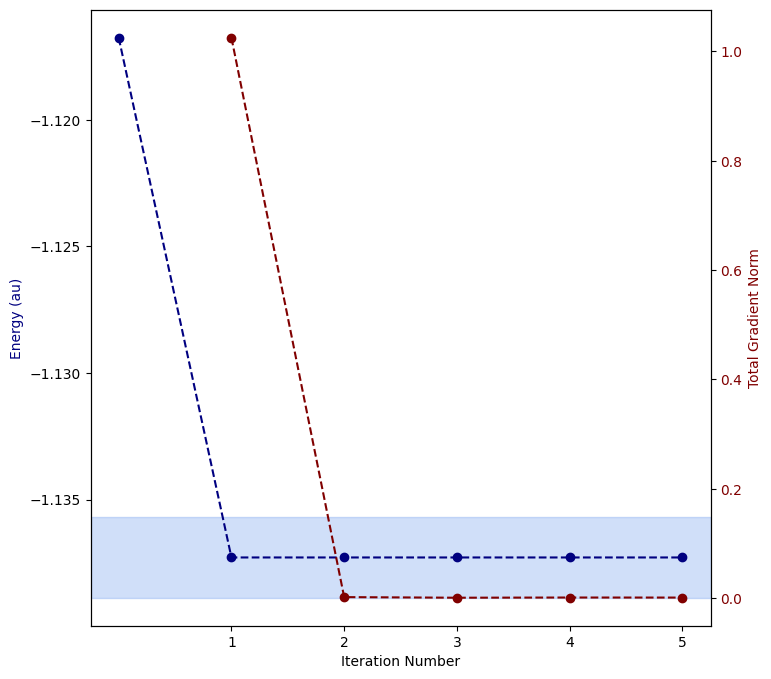

In [98]:
data.plot()

In [99]:
evolution = adapt_vqe_h2.opt_evolution
evolution

{'nfev': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 'parameters': [[0.11310341637413987,
   -0.0004941056255980852,
   0.00012393342237914195,
   0.00014477657794398355,
   0.0],
  [0.21310341637413988,
   -0.0004941056255980852,
   0.00012393342237914195,
   0.00014477657794398355,
   0.0],
  [0.11310341637413987,
   0.09950589437440192,
   0.00012393342237914195,
   0.00014477657794398355,
   0.0],
  [0.11310341637413987,
   -0.0004941056255980852,
   0.10012393342237914,
   0.00014477657794398355,
   0.0],
  [0.11310341637413987,
   -0.0004941056255980852,
   0.00012393342237914195,
   0.10014477657794399,
   0.0],
  [0.11310341637413987,
   -0.0004941056255980852,
   0.00012393342237914195,
   0.00014477657794398355,
   0.1],
  [0.06838205682414358,
   -0.04521546517559437,
   -0.04459742612761714,
   

In [100]:
print(data.result)

{'ansatz': [1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3], 1j [X0 X1 Y2 X3]], 'coefficients': [0.11305758727074554, -0.0002401889463698475, 3.092583685089631e-05, -4.2213676779687424e-05, 8.922333059783648e-05], 'indices': [8, 8, 8, 8, 8], 'ansatz performances': [0.056631581539837696, 8.226316713857607e-05, 5.307442504306011e-05, 1.0459155129570642e-05, 1.888756132926769e-05], 'performances': [0.056631581539837696, 8.226316713857607e-05, 5.307442504306011e-05, 1.0459155129570642e-05, 1.888756132926769e-05], 'energy': -1.1372838139799997, 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 2 stored elements in Compressed Sparse Column format>, 'total norm': 0.000872532081906502}


In [101]:
evolution['parameters']

[[0.11310341637413987,
  -0.0004941056255980852,
  0.00012393342237914195,
  0.00014477657794398355,
  0.0],
 [0.21310341637413988,
  -0.0004941056255980852,
  0.00012393342237914195,
  0.00014477657794398355,
  0.0],
 [0.11310341637413987,
  0.09950589437440192,
  0.00012393342237914195,
  0.00014477657794398355,
  0.0],
 [0.11310341637413987,
  -0.0004941056255980852,
  0.10012393342237914,
  0.00014477657794398355,
  0.0],
 [0.11310341637413987,
  -0.0004941056255980852,
  0.00012393342237914195,
  0.10014477657794399,
  0.0],
 [0.11310341637413987,
  -0.0004941056255980852,
  0.00012393342237914195,
  0.00014477657794398355,
  0.1],
 [0.06838205682414358,
  -0.04521546517559437,
  -0.04459742612761714,
  -0.044576582972052296,
  -0.04472135954999383],
 [0.09074273659914173,
  -0.02285478540059623,
  -0.022236746352619,
  -0.022215903197054156,
  -0.022360679774996915],
 [0.13757424691858386,
  -0.003052349772718693,
  -0.0024343107247414664,
  -0.0024134675691766245,
  -0.002558244

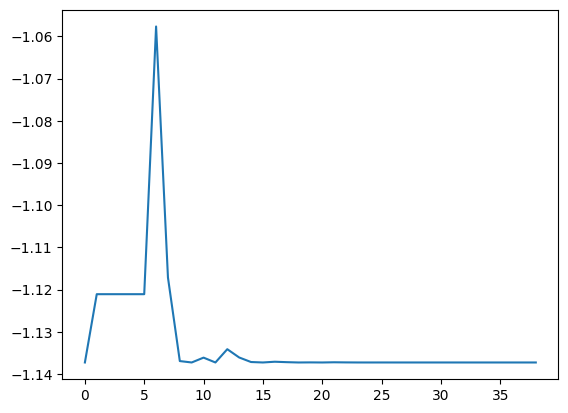

In [102]:
plt.plot(evolution['energy'])


Calculate Energy -> Ket:   (12, 0)	(1+0j)
Coefficients: 0.11310341637413987 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: -0.0004941056255980852 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.00012393342237914195 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.00014477657794398355 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.0 Indices: 8 operator 1j [X0 X1 Y2 X3]
Calculate Energy -> Bra:   (0, 3)	(-0.11263846851475297-0j)
  (0, 12)	(0.99363603769723-0j)
Calculate Energy -> Energy: -1.1372838198065607

Calculate Energy -> Ket:   (12, 0)	(1+0j)
Coefficients: 0.21310341637413988 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: -0.0004941056255980852 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.00012393342237914195 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.00014477657794398355 Indices: 8 operator 1j [X0 X1 Y2 X3]
Coefficients: 0.0 Indices: 8 operator 1j [X0 X1 Y2 X3]
Calculate Energy -> Bra:   (0, 3)	(-0.211273825889448-0j)
  (0, 12)	(0.9774269

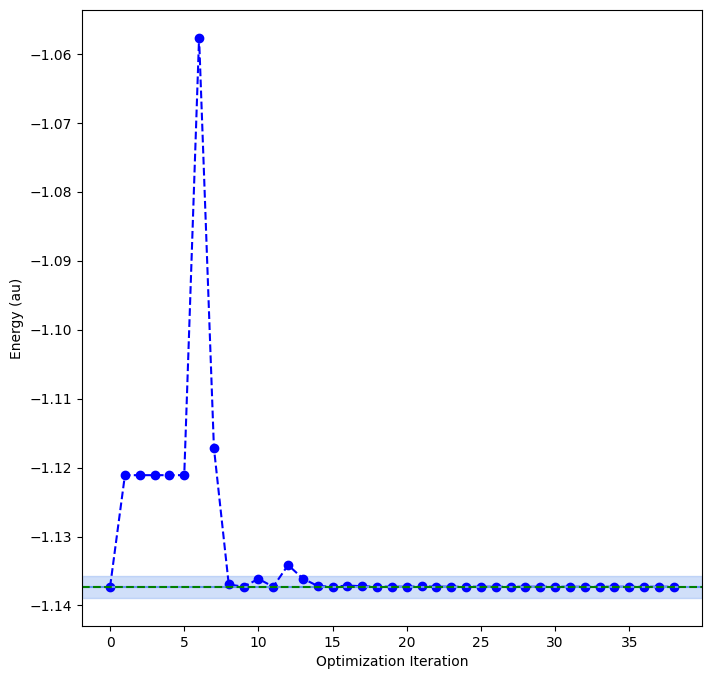

In [103]:
nfev = evolution["nfev"][-1]
energies = []
exact_energy = -1.13728


for i in range(nfev):
  optimized_coefficients = list(evolution["parameters"][i])
  energy = adapt_vqe_h2.calculateEnergy(optimized_coefficients, data.result["indices"])
  energies.append(energy)

fig, ax1 = plt.subplots(figsize=[8,8])

nfev = evolution["nfev"][-1]

color1 = 'b'
ax1.plot(range(nfev), energies, '--o', color = color1)
ax1.set_xlabel("Optimization Iteration")
ax1.set_ylabel("Energy (au)")


minAccuracy = exact_energy - chemicalAccuracy
maxAccuracy = exact_energy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')
plt.axhline(y = exact_energy, color = 'cornflowerblue' , linestyle = '-')
plt.axhline(-1.13728, color='green', linestyle='--')

In [104]:
adapt_vqe_h2.data.result

{'ansatz': [1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3],
  1j [X0 X1 Y2 X3]],
 'coefficients': [0.11305758727074554,
  -0.0002401889463698475,
  3.092583685089631e-05,
  -4.2213676779687424e-05,
  8.922333059783648e-05],
 'indices': [8, 8, 8, 8, 8],
 'ansatz performances': [0.056631581539837696,
  8.226316713857607e-05,
  5.307442504306011e-05,
  1.0459155129570642e-05,
  1.888756132926769e-05],
 'performances': [0.056631581539837696,
  8.226316713857607e-05,
  5.307442504306011e-05,
  1.0459155129570642e-05,
  1.888756132926769e-05],
 'energy': -1.1372838139799997,
 'state': <16x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 'total norm': 0.000872532081906502}

In [105]:
print(type(adapt_vqe_h2.data))

<class '__main__.AdaptVQEData'>
